In [45]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Activation ,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc,precision_score, recall_score,f1_score,accuracy_score
from sklearn.model_selection import StratifiedKFold
from scipy import interp
import matplotlib.pyplot as plt
from skimage import transform
import scipy.ndimage
import matplotlib.pyplot as plt

from keras.layers import Lambda, Input
from keras.models import Model, Sequential
import tensorflow as ktf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [46]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Train data shape: {}'.format(X_train.shape))
print('Test  data shape: {}'.format(X_test.shape))

Train data shape: (50000, 32, 32, 3)
Test  data shape: (10000, 32, 32, 3)


In [47]:
image_size = 32
num_channels = 3
num_features = image_size * image_size * num_channels
num_classes = 10

In [48]:
X_train = X_train.astype('float32')
x_test  = X_test.astype('float32')

X_train /= 255.0
mean = np.mean(X_train, axis=(0, 1, 2,3))
std = np.std(X_train, axis=(0, 1, 2,3))
X_train = (X_train - mean)/ (std+1e-7)

x_test /= 255.0

x_test =(x_test-mean) / (std+1e-7)

print(X_train.shape)
print(x_test.shape)


(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [49]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


In [50]:
# plotting helper function
def plothist(hist):
    
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')


    plt.show()

In [51]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-_cyl97ki
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-_cyl97ki
  Running command git submodule update --init --recursive -q
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp36-none-any.whl size=20031 sha256=9eb68f7741f8fc5d0fef73ffec3cbe11346880e76a8e33672f0740deef41e987
  Stored in directory: /tmp/pip-ephem-wheel-cache-c4cf67nk/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [52]:
from classification_models.tfkeras import Classifiers

In [53]:
ResNet18, preprocess_input = Classifiers.get('resnet18')
resnet18 = ResNet18((224, 224, 3), weights='imagenet')
resnet18.summary() 

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_36 (ZeroPadding2 (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_36[0][0]          
______________________________________________________________________________________

In [54]:
alpha = 0.003  # weight decay coefficient

for layer in resnet18.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.kernel))
    if hasattr(layer, 'bias_regularizer') and layer.use_bias:
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.bias))

In [55]:
x = resnet18.layers[-2].output
output = Dense(units=10,activation='softmax')(x)
model = Model(inputs=[resnet18.input], outputs=[output])
#model.summary()

In [56]:
for layer in model.layers[35:]:
    layer.trainable = True
for layer in model.layers[:35]:
    layer.trainable = False
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 data False
1 bn_data False
2 zero_padding2d_36 False
3 conv0 False
4 bn0 False
5 relu0 False
6 zero_padding2d_37 False
7 pooling0 False
8 stage1_unit1_bn1 False
9 stage1_unit1_relu1 False
10 zero_padding2d_38 False
11 stage1_unit1_conv1 False
12 stage1_unit1_bn2 False
13 stage1_unit1_relu2 False
14 zero_padding2d_39 False
15 stage1_unit1_conv2 False
16 stage1_unit1_sc False
17 add_16 False
18 stage1_unit2_bn1 False
19 stage1_unit2_relu1 False
20 zero_padding2d_40 False
21 stage1_unit2_conv1 False
22 stage1_unit2_bn2 False
23 stage1_unit2_relu2 False
24 zero_padding2d_41 False
25 stage1_unit2_conv2 False
26 add_17 False
27 stage2_unit1_bn1 False
28 stage2_unit1_relu1 False
29 zero_padding2d_42 False
30 stage2_unit1_conv1 False
31 stage2_unit1_bn2 False
32 stage2_unit1_relu2 False
33 zero_padding2d_43 False
34 stage2_unit1_conv2 False
35 stage2_unit1_sc True
36 add_18 True
37 stage2_unit2_bn1 True
38 stage2_unit2_relu1 True
39 zero_padding2d_44 True
40 stage2_unit2_conv1 True
41 stage2

In [57]:
newInput = Input(batch_shape=(None, 32, 32, 3))
resizedImg = Lambda(lambda image: ktf.image.resize(image, (224, 224)))(newInput)
newOutputs = model(resizedImg)
model = Model(newInput, newOutputs)

In [58]:
BATCH_SIZE =100
STEPS_PER_EPOCH =len(X_train)//BATCH_SIZE 

step = tf.Variable(0, trainable=False)
boundaries = [30*STEPS_PER_EPOCH,50*STEPS_PER_EPOCH,80*STEPS_PER_EPOCH]
values = [ 0.1, 0.01,0.001,0.0001]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

In [59]:
opt = SGD(learning_rate=learning_rate_fn)#,momentum=0.9,decay=0.01,nesterov=False
#opt = Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.99,epsilon=0.1,amsgrad=False,name="Adam",)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

In [60]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [61]:
history =model.fit(X_train, y_train, batch_size=100,
                   steps_per_epoch=len(X_train) // 100,epochs=100,
                   validation_data=(x_test,y_test))

Epoch 1/100
500/500 [==============================] - 108s 216ms/step - loss: 4.1593 - accuracy: 0.1506 - val_loss: 6.1092 - val_accuracy: 0.0958
Epoch 2/100
500/500 [==============================] - 108s 216ms/step - loss: 3.7771 - accuracy: 0.1995 - val_loss: 3.7073 - val_accuracy: 0.2122
Epoch 3/100
500/500 [==============================] - 108s 216ms/step - loss: 3.5883 - accuracy: 0.2327 - val_loss: 3.5569 - val_accuracy: 0.2413
Epoch 4/100
500/500 [==============================] - 108s 216ms/step - loss: 3.4682 - accuracy: 0.2575 - val_loss: 3.4493 - val_accuracy: 0.2651
Epoch 5/100
500/500 [==============================] - 108s 216ms/step - loss: 3.3816 - accuracy: 0.2781 - val_loss: 3.3712 - val_accuracy: 0.2832
Epoch 6/100
500/500 [==============================] - 108s 216ms/step - loss: 3.3147 - accuracy: 0.2963 - val_loss: 3.3099 - val_accuracy: 0.2988
Epoch 7/100
500/500 [==============================] - 108s 216ms/step - loss: 3.2610 - accuracy: 0.3090 - val_loss: 3

In [62]:
#model.save('cifar10.simplenet2.h5')
                 
#model=load_model('cifar10_01.h5')

In [63]:
y_pred = model.predict(x_test)
labels1 = np.arange(num_classes)
print('Auc = %f' %  (roc_auc_score(y_test,  y_pred.round(),average='macro',multi_class='ovo',labels=labels1)))
print('f1_score = %f' % (f1_score(y_test, y_pred.round(), average="macro")))
print('precision = %f' % (precision_score(y_test, y_pred.round(), average="macro")))
print('recall  = %f' % (recall_score(y_test, y_pred.round(), average="macro")))
print('accuracy  = %f' % (accuracy_score(y_test, y_pred.round()))) 

Auc = 0.599039
f1_score = 0.299960
precision = 0.606805
recall  = 0.211900
accuracy  = 0.211900


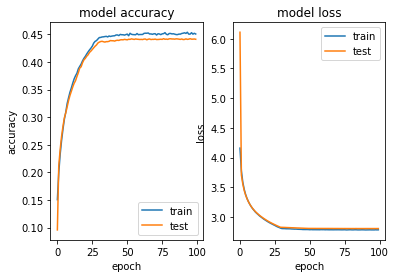

In [64]:
plothist(history)